In [4]:
!pip install mne
!pip install mneflow

In [5]:
# Here we use the same dataset as in the basic mneflow example
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow


fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
print(epochs.info)

<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 5 10.000000 500.000000 6 10.000000 500.000000
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0122, MEG 0123, MEG 0132, MEG 0133, MEG ...
 chs: 204 GRAD
 custom_ref_applied: False
 description: Vectorview system at BioMag
 dev_head_t: MEG device -> head transform
 dig: 21 items (3 Cardinal, 4 HPI, 14 Extra)
 events: 1 item (list)
 experimenter: neuromag
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2011-04-26 11:33:18 UTC
 meas_id: 4 items (dict)
 nchan: 204
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: grad_ssp_upright.fif : PCA-v1: on, grad_ssp_upright.fif : ...
 sfreq: 600.6 Hz
 subject_info: 9 items (dict)
>


In [10]:
import numpy as np
import mne
from mne.datasets import multimodal
import os
import tensorflow as tf
import mneflow

mne.set_log_level(verbose='CRITICAL')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [ ]:
OpenMIIR_data_path = '/content/drive/MyDrive/Brain-Computer Interfaces/OpenMIIR Data/'
file_name = 'P05-raw.fif'
raw = mne.io.read_raw_fif(OpenMIIR_data_path + file_name)
cond = raw.A.get_condition(raw, None)
condition_names = [k for c in cond for k, v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(eeg='grad')

In [2]:
!pip install mne

     |████████████████████████████████| 7.0MB 2.1MB/s 


In [3]:
from collections import OrderedDict
from pylab import rcParams
import torch
import torch.nn as nn
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
import mne
from sklearn.preprocessing import RobustScaler

In [4]:
torch.manual_seed(100)

In [5]:
# Initialize parameters
eeg_sample_count = 240 # How many samples are we training
learning_rate = 1e-3 # How hard the network will correct its mistakes while learning
eeg_sample_length = 226 # Number of eeg data points per sample
number_of_classes = 1 # We want to answer the "is this a P300?" question
hidden1 = 500 # Number of neurons in our first hidden layer
hidden2 = 1000 # Number of neurons in our second hidden layer
hidden3 = 100 # Number of neurons in our third hidden layer
output = 10 # Number of neurons in our output layer

In [6]:
## Create sample data using the parameters
sample_positives = [None, None] # Element [0] is the sample, Element [1] is the class
sample_positives[0] = torch.rand(int(eeg_sample_count / 2), eeg_sample_length) * 0.50 + 0.25
sample_positives[1] = torch.ones([int(eeg_sample_count / 2), 1], dtype=torch.float32)

sample_negatives = [None, None] # Element [0] is the sample, Element [1] is the class
sample_negatives_low = torch.rand(int(eeg_sample_count / 4), eeg_sample_length) * 0.25
sample_negatives_high = torch.rand(int(eeg_sample_count / 4), eeg_sample_length) * 0.25 + 0.75
sample_negatives[0] = torch.cat([sample_negatives_low, sample_negatives_high], dim = 0)
sample_negatives[1] = torch.zeros([int(eeg_sample_count / 2), 1], dtype=torch.float32)

samples = [None, None] # Combine the two
samples[0] = torch.cat([sample_positives[0], sample_negatives[0]], dim = 0)
samples[1] = torch.cat([sample_positives[1], sample_negatives[1]], dim = 0)

## Create test data that isn't trained on
test_positives = torch.rand(10, eeg_sample_length) * 0.50 + 0.25 # Test 10 good samples
test_negatives_low = torch.rand(5, eeg_sample_length) * 0.25 # Test 5 bad low samples
test_negatives_high = torch.rand(5, eeg_sample_length) * 0.25 + 0.75 # Test 5 bad high samples
test_negatives = torch.cat([test_negatives_low, test_negatives_high], dim = 0)

print("We have created a sample dataset with " + str(samples[0].shape[0]) + " samples")
print("Half of those are positive samples with a score of 100%")
print("Half of those are negative samples with a score of 0%")
print("We have also created two sets of 10 test samples to check the validity of the network")

We have created a sample dataset with 240 samples
Half of those are positive samples with a score of 100%
Half of those are negative samples with a score of 0%
We have also created two sets of 10 test samples to check the validity of the network


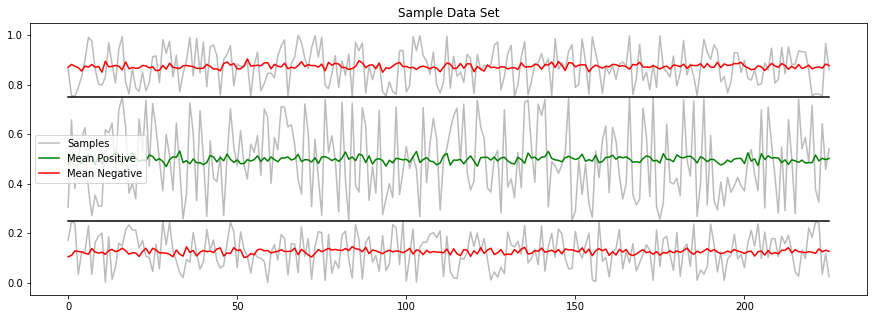

In [7]:
rcParams['figure.figsize'] = 15, 5

plt.title("Sample Data Set")
plt.plot(list(range(0, eeg_sample_length)), sample_positives[0][0], color = "#bbbbbb", label = "Samples")
plt.plot(list(range(0, eeg_sample_length)), sample_positives[0].mean(dim = 0), color = "g", label = "Mean Positive")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_high[0], color = "#bbbbbb")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_high.mean(dim = 0), color = "r", label = "Mean Negative")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_low[0], color = "#bbbbbb")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_low.mean(dim = 0), color = "r")
plt.plot(list(range(0, eeg_sample_length)), [0.75] * eeg_sample_length, color = "k")
plt.plot(list(range(0, eeg_sample_length)), [0.25] * eeg_sample_length, color = "k")
plt.legend()
plt.show()

In [8]:
## Define the network
tutorial_model = nn.Sequential()

# Input Layer (Size 226 -> 500)
tutorial_model.add_module('Input Linear', nn.Linear(eeg_sample_length, hidden1))
tutorial_model.add_module('Input Activation', nn.CELU()) 

# Hidden Layer (Size 500 -> 1000)
tutorial_model.add_module('Hidden Linear', nn.Linear(hidden1, hidden2))
tutorial_model.add_module('Hidden Activation', nn.ReLU())

# Hidden Layer (Size 1000 -> 100)
tutorial_model.add_module('Hidden Linear2', nn.Linear(hidden2, hidden3))
tutorial_model.add_module('Hidden Activation2', nn.ReLU())

# Hidden Layer (Size 100 -> 10)
tutorial_model.add_module('Hidden Linear3', nn.Linear(hidden3, 10))
tutorial_model.add_module('Hidden Activation3', nn.ReLU())

# Output Layer (Size 10 -> 1)
tutorial_model.add_module('Output Linear', nn.Linear(10, number_of_classes))
tutorial_model.add_module('Output Activation', nn.Sigmoid())

In [9]:
# Define a loss function
loss_function = torch.nn.MSELoss()

# Define a training procedure
def train_network(train_data, actual_class, iterations):

  # Keep track of loss at every training iteration
  loss_data = []

  # Begin training for a certain amount of iterations
  for i in range(iterations):

    # Begin with a classification
    classification = tutorial_model(train_data)

    # Find out how wrong the network was
    loss = loss_function(classification, actual_class)
    loss_data.append(loss)

    # Zero out the optimizer gradients every iteration
    optimizer.zero_grad()

    # Teach the network how to do better next time
    loss.backward()
    optimizer.step()
  
  # Plot a nice loss graph at the end of training
  rcParams['figure.figsize'] = 10, 5
  plt.title("Loss vs Iterations")
  plt.plot(list(range(0, len(loss_data))), loss_data)
  plt.show()

# Save the network's default state so we can retrain from the default weights
torch.save(tutorial_model, "/home/tutorial_model_default_state")

Below is the loss graph for our training session


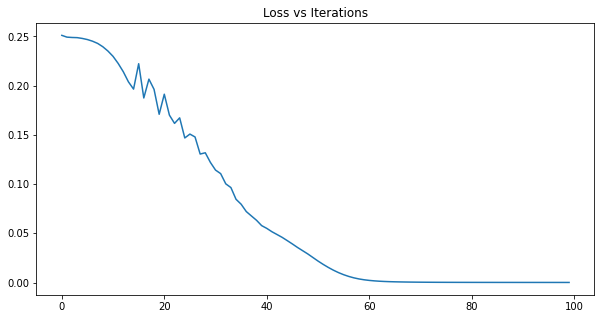

In [10]:
# Make sure we're starting from untrained every time
tutorial_model = torch.load("/home/tutorial_model_default_state")

# Define a learning function, needs to be reinitialized every load
optimizer = torch.optim.Adam(tutorial_model.parameters(), lr = learning_rate)

# Train the network using our training procedure with the sample data
print("Below is the loss graph for our training session")
train_network(samples[0], samples[1], iterations = 100)

Positive Test 1 Value scored: 98.68%
Positive Test 2 Value scored: 99.10%
Positive Test 3 Value scored: 99.01%
Positive Test 4 Value scored: 99.25%
Positive Test 5 Value scored: 98.91%
Positive Test 6 Value scored: 99.08%
Positive Test 7 Value scored: 98.82%
Positive Test 8 Value scored: 99.01%
Positive Test 9 Value scored: 98.30%
Positive Test 10 Value scored: 99.24%

Negative Test 1 Value scored: 1.38%
Negative Test 2 Value scored: 1.15%
Negative Test 3 Value scored: 1.68%
Negative Test 4 Value scored: 1.11%
Negative Test 5 Value scored: 0.97%
Negative Test 6 Value scored: 0.81%
Negative Test 7 Value scored: 0.79%
Negative Test 8 Value scored: 0.88%
Negative Test 9 Value scored: 0.66%
Negative Test 10 Value scored: 1.06%

Below is a scatter plot of some of the samples
Notice the distinct areas of red and green dots. If the input of this 
network was a simple x and y coordinate, the square band in the center would 
represent the "solution space" of our network. However, an actual EEG 

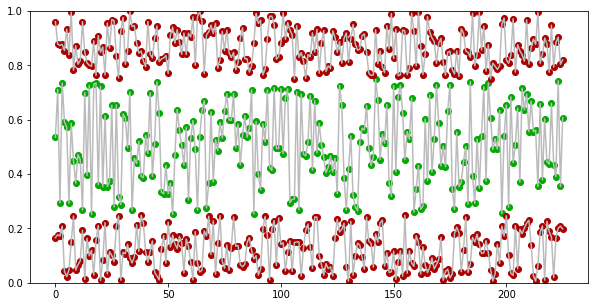

In [11]:
# Classify our positive test dataset
predicted_positives = tutorial_model(test_positives).data.tolist()

# Print the results
for index, value in enumerate(predicted_positives):
  print("Positive Test {1} Value scored: {0:.2f}%".format(value[0] * 100, index + 1))

print()

#Classify the negative test dataset
predicted_negatives = tutorial_model(test_negatives).data.tolist()

# Print the results
for index, value in enumerate(predicted_negatives):
  print("Negative Test {1} Value scored: {0:.2f}%".format(value[0] * 100, index + 1))

print()


print("Below is a scatter plot of some of the samples")
print("Notice the distinct areas of red and green dots. If the input of this \n" +
"network was a simple x and y coordinate, the square band in the center would \n" +
"represent the \"solution space\" of our network. However, an actual EEG signal \n" +
"sample is an array of several points and can cross the boundry at any time.")
print("Plotted is one positive sample in green and two negative samples in red")

rcParams['figure.figsize'] = 10, 5
plt.scatter(list(range(0, eeg_sample_length)), test_positives[3], color = "#00aa00")
plt.plot(list(range(0, eeg_sample_length)), test_positives[3], color = "#bbbbbb")
plt.scatter(list(range(0, eeg_sample_length)), test_negatives[0], color = "#aa0000")
plt.plot(list(range(0, eeg_sample_length)), test_negatives[0], color = "#bbbbbb")
plt.scatter(list(range(0, eeg_sample_length)), test_negatives[9], color = "#aa0000")
plt.plot(list(range(0, eeg_sample_length)), test_negatives[9], color = "#bbbbbb")
plt.ylim([0 , 1])
plt.show()

In [15]:
OpenMIIR_data_path = '/content/drive/MyDrive/Brain-Computer Interfaces/OpenMIIR Data/'
file_name = 'P05-raw.fif'
raw_data = mne.io.read_raw_fif(OpenMIIR_data_path + file_name)

Opening raw data file /content/drive/MyDrive/Brain-Computer Interfaces/OpenMIIR Data/P05-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2521101 =      0.000 ...  4924.025 secs
Ready.


In [16]:
# Define what data we want from the dataset
raw_data = raw_data.pick(picks=["eeg","eog"])
picks_eeg_only = mne.pick_types(raw_data.info, 
                                eeg=True, 
                                eog=True, 
                                meg=False, 
                                exclude='bads')

Removing projector <Projection | Average EEG reference, active : False, n_channels : 64>


In [20]:
events = mne.find_events(raw)
print(events[:5])  # show the first 5
print('# of event ids:', len(set(events[:, 2])))

540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
[[  512     0   121]
 [  520     0  1000]
 [ 8189     0   122]
 [ 8195     0  1000]
 [16564     0   123]]
# of event ids: 52


In [ ]:
events = mne.read_events(event_fname)
event_id = 5
tmin = -0.5 
tmax = 1
epochs = mne.Epochs(raw_data, events, event_id, tmin, tmax, proj=True,
                    picks=picks_eeg_only, baseline=(None, 0), preload=True,
                    reject=dict(eeg=100e-6, eog=150e-6), verbose = False)
print(epochs)